In [ ]:
# https://jacobgil.github.io/pytorch-gradcam-book/CAM%20Metrics%20And%20Tuning%20Tutorial.html

In [2]:
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from torchvision.models import resnet50
import sys
sys.path.append("../")
# sys.path.append("../local_configs/SynthDet")
from models.builder import EncoderDecoder as segmodel
from utils.dataloader.RGBXDataset import RGBXDataset
from utils.dataloader.dataloader import get_train_loader,get_val_loader
from PIL import Image
import torch
from torchvision import transforms
import os
import os.path as osp
import numpy as np
import importlib
import torch.nn as nn

class SegmentationModelOutputWrapper(torch.nn.Module):
    def __init__(self, model): 
        super(SegmentationModelOutputWrapper, self).__init__()
        self.model = model
        
    def forward(self, x):
        rgb = x[:, 0, :, :, :]
        depth = x[:, 1, :, :, :]
        return self.model(rgb, depth)
    
class SemanticSegmentationTarget:
    def __init__(self, category, mask):
        self.category = category
        self.mask = torch.from_numpy(mask)
        if torch.cuda.is_available():
            self.mask = self.mask.cuda()
        
    def __call__(self, model_output):
        return (model_output[self.category, :, : ] * self.mask).sum()
    
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

experiment = "color_back_shape"

# Check if the file exists
model_path = f"../checkpoints/SynthDet_{experiment}_DFormer-Tiny/"
first_run_directory = ""
for dir in os.listdir(model_path):
    if "run" in dir:
        first_run_directory = dir
        break
last_epoch_file = ""
for file in os.listdir(model_path + first_run_directory):
    if ".pth" in file:
        last_epoch_file = file

model_path = model_path + first_run_directory + "/" + last_epoch_file

config_path = f"local_configs.SynthDet.SynthDet_{experiment}_Dformer_Tiny"

if not os.path.exists(model_path):
    print("Model file does not exist")
    exit()

config_module = importlib.import_module(config_path)
config = config_module.config
config.root_dir = "../datasets"
config.dataset_path = osp.join(config.root_dir, config.dataset_name)
config.rgb_root_folder = osp.join(config.dataset_path, 'RGB')
config.gt_root_folder = osp.join(config.dataset_path, 'labels')
config.x_root_folder = osp.join(config.dataset_path, 'Depth_original')
config.train_source = osp.join(config.dataset_path, "train.txt")
config.eval_source = osp.join(config.dataset_path, "test.txt")


model=segmodel(cfg=config, criterion=nn.CrossEntropyLoss(reduction='mean'), norm_layer=nn.BatchNorm2d)
try:
    model_state_dict = torch.load(model_path)
except Exception as e:
    print(f"Failed to load model: {e}")
    exit()

model.load_state_dict(model_state_dict['model'])
model = model.eval()

target_layers = [model.backbone.downsample_layers[0], model.backbone.downsample_layers[1], model.backbone.downsample_layers[2], model.backbone.downsample_layers[3],
                 model.backbone.downsample_layers_e[0], model.backbone.downsample_layers_e[1], model.backbone.downsample_layers_e[2], model.backbone.downsample_layers_e[3]]

target_layers += [model.decode_head.conv_seg, model.decode_head.squeeze.conv, model.decode_head.hamburger, model.decode_head.hamburger.ham_in.conv, model.decode_head.hamburger.ham_out.conv, model.decode_head.align.conv]

val_loader, val_sampler = get_val_loader(None, RGBXDataset,config,1)

dataloader = iter(val_loader)
data = next(dataloader)
image_tensor = data['data']
depth_tensor = data['modal_x']
target = data['label']
print(target.unique())

image = image_tensor[0].permute(1, 2, 0).numpy()
depth = depth_tensor[0].permute(1, 2, 0).numpy()

image = (image - image.min()) / (image.max() - image.min())
depth = (depth - depth.min()) / (depth.max() - depth.min())
image = image.astype(np.float32)
depth = depth.astype(np.float32)

input_tensor = torch.stack([image_tensor, depth_tensor], dim=1)

input_tensor = input_tensor.to(device)
model = model.to(device)

model = SegmentationModelOutputWrapper(model)

# Construct the CAM object once, and then re-use it on many images:
cam = GradCAM(model=model, target_layers=target_layers)
# cam = EigenCAM(model=model, target_layers=target_layers)

# You can also use it within a with statement, to make sure it is freed,
# In case you need to re-create it inside an outer loop:
# with GradCAM(model=model, target_layers=target_layers) as cam:
#   ...

# We have to specify the target we want to generate
# the Class Activation Maps for.
# If targets is None, the highest scoring category
# will be used for every image in the batch.
# Here we use ClassifierOutputTarget, but you can define your own custom targets
# That are, for example, combinations of categories, or specific outputs in a non standard model.
category = 8

targets = [SemanticSegmentationTarget(category, (target.cpu().numpy()[0] == category))]

# You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
grayscale_cam = cam(input_tensor=input_tensor, targets=targets)

# In this example grayscale_cam has only one image in the batch:
grayscale_cam = grayscale_cam[0, :]
visualization = show_cam_on_image(image, grayscale_cam, use_rgb=True)

# You can also get the model outputs without having to re-inference
model_outputs = cam.outputs

c:\Users\Pasca\anaconda3\envs\dformer_original\lib\site-packages\mmcv\__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(
05 12:21:22 Using Ham Decoder
g:\mscPascalBenschop\code\DFormer\utils\..\models\losses\cross_entropy_loss.py:235: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  warnings.warn(
05 12:21:22 Initing weights ...


single GPU
0.1
17
spatial True
S 1
D 512
R 64
train_steps 6
eval_steps 7
inv_t 100
eta 0.9
rand_init True
tensor([ 0,  2,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 16])


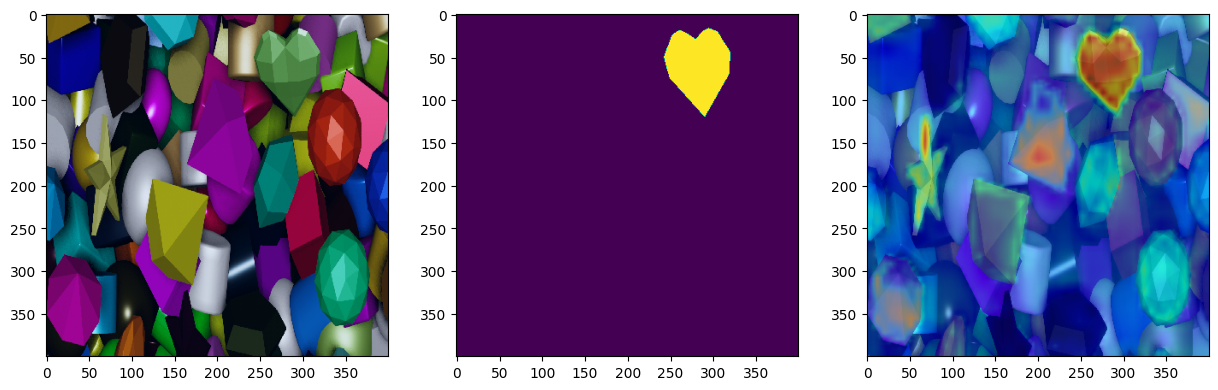

In [4]:
cam_image = show_cam_on_image(image, grayscale_cam, use_rgb=True)

import matplotlib.pyplot as plt
mask = target.cpu().numpy()[0] == category
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(image)
ax[1].imshow(mask)
ax[2].imshow(cam_image)

In [5]:
from pytorch_grad_cam.utils.model_targets import ClassifierOutputSoftmaxTarget
from pytorch_grad_cam.metrics.cam_mult_image import CamMultImageConfidenceChange
import numpy as np

grayscale_cams = [grayscale_cam]
inverse_cams = [1 - grayscale_cam]


# Create the metric target, often the confidence drop in a score of some category
metric_target = ClassifierOutputSoftmaxTarget(category)
scores_1, batch_visualizations = CamMultImageConfidenceChange()(input_tensor, 
  inverse_cams, targets, model, return_visualization=True)
# visualization = deprocess_image(batch_visualizations[0, :])

# State of the art metric: Remove and Debias
from pytorch_grad_cam.metrics.road import ROADMostRelevantFirst, ROADLeastRelevantFirst
cam_metric = ROADMostRelevantFirst(percentile=75)
scores_2, perturbation_visualizations = cam_metric(input_tensor, 
  grayscale_cams, targets, model, return_visualization=True)

# You can also average accross different percentiles, and combine
# (LeastRelevantFirst - MostRelevantFirst) / 2
from pytorch_grad_cam.metrics.road import ROADMostRelevantFirstAverage,ROADLeastRelevantFirstAverage, ROADCombined
cam_metric = ROADCombined(percentiles=[20, 40, 60, 80])
scores_3 = cam_metric(input_tensor, grayscale_cams, targets, model)

[-102029.58] [-103879.15] [52253.64]


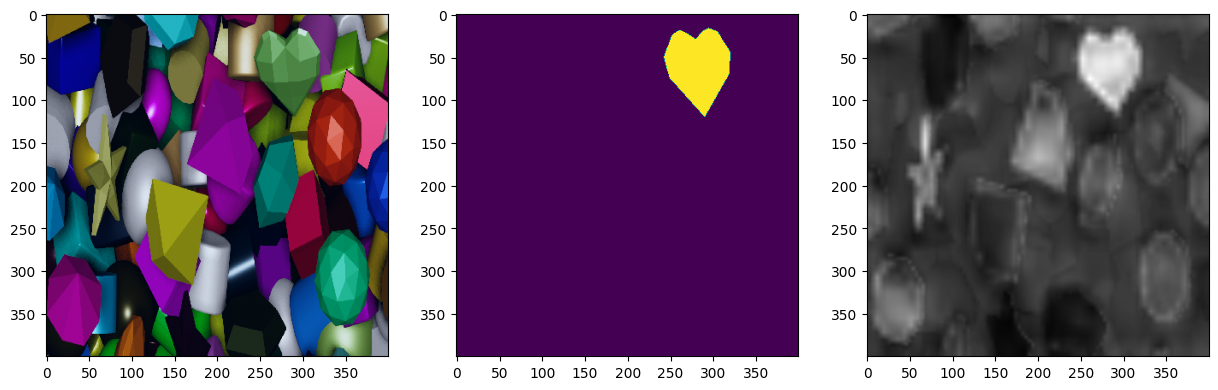

In [6]:
print(scores_1, scores_2, scores_3)
import matplotlib.pyplot as plt
# plt.imshow(grayscale_cam, cmap='gray')
# plt.show()
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(image)
ax[1].imshow(mask)
ax[2].imshow(grayscale_cam, cmap='gray')

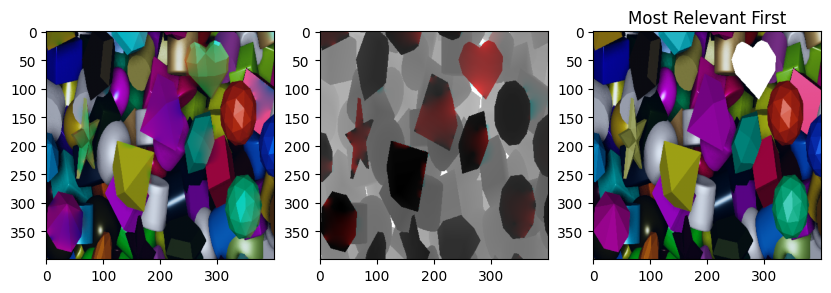

In [7]:

import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 3, figsize=(10, 5))
pv_0 = perturbation_visualizations[0, 0]
pv_0_norm = (pv_0 - pv_0.min()) / (pv_0.max() - pv_0.min())
pv_1 = perturbation_visualizations[0, 1]
pv_1_norm = (pv_1 - pv_1.min()) / (pv_1.max() - pv_1.min())

plt.title("Most Relevant First")

ax[0].imshow(pv_0_norm.permute(1, 2, 0).cpu().numpy())
ax[1].imshow(pv_1_norm.permute(1, 2, 0).cpu().numpy())
ax[2].imshow(np.maximum(image, np.expand_dims(mask, axis=2).repeat(3, axis=2)))


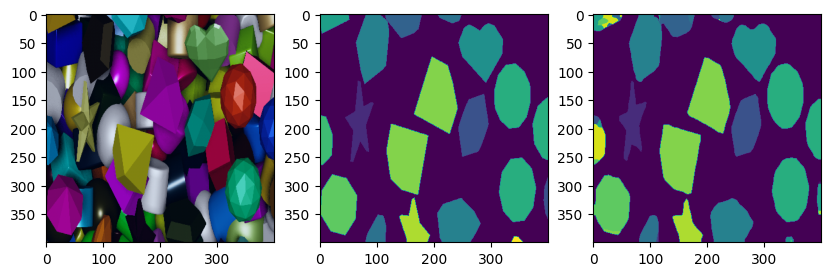

In [8]:
fig, ax = plt.subplots(1, 3, figsize=(10, 5))
ax[0].imshow(image)
ax[1].imshow(target.cpu().numpy()[0])
ax[2].imshow(model_outputs[0].argmax(0).cpu().numpy())

torch.Size([1, 2, 3, 400, 400])


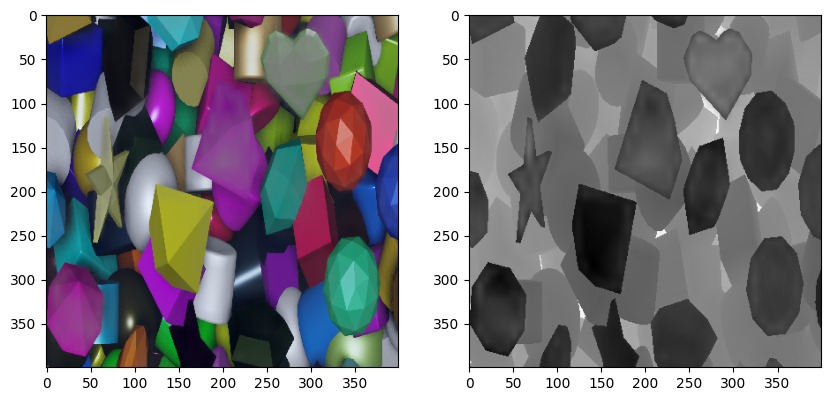

In [9]:
print(batch_visualizations.shape)
bv_0 = batch_visualizations[0, 0]
bv_0_norm = (bv_0 - bv_0.min()) / (bv_0.max() - bv_0.min())
bv_1 = batch_visualizations[0, 1]
bv_1_norm = (bv_1 - bv_1.min()) / (bv_1.max() - bv_1.min())

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(bv_0_norm.permute(1, 2, 0).cpu().numpy())
ax[1].imshow(bv_1_norm.permute(1, 2, 0).cpu().numpy())


torch.Size([1, 2, 3, 400, 400])
The confidence increase when removing 25% of the image: -104523.0390625
(400, 400, 3) (400, 400, 3)
The confidence increase when removing 10% of the image: -101481.703125
The visualizations:


Text(0.5, 1.0, '90th percentile')

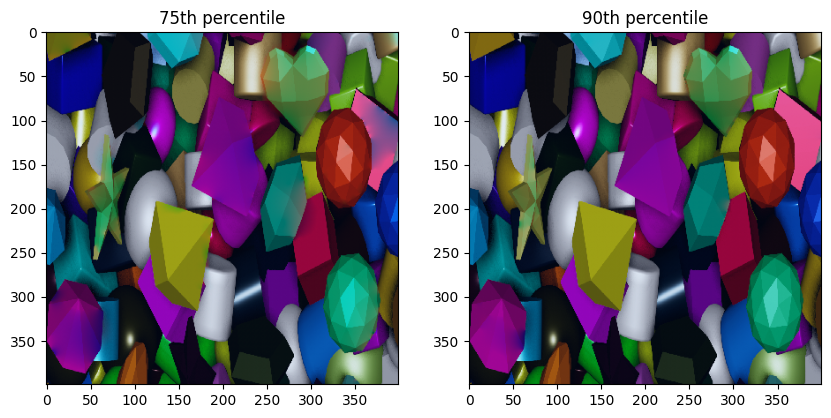

In [10]:
from pytorch_grad_cam.metrics.road import ROADMostRelevantFirst
cam_metric = ROADMostRelevantFirst(percentile=75)
scores, visualizations = cam_metric(input_tensor, grayscale_cams, targets, model, return_visualization=True)
print(visualizations.shape)
score = scores[0]
visualization = visualizations[0, 0].cpu().numpy().transpose((1, 2, 0))
# visualization = deprocess_image(visualization)
print(f"The confidence increase when removing 25% of the image: {score}")

cam_metric = ROADMostRelevantFirst(percentile=90)
scores, visualizations = cam_metric(input_tensor, grayscale_cams, targets, model, return_visualization=True)
score = scores[0]
visualization_10 = visualizations[0, 0].cpu().numpy().transpose((1, 2, 0))
# visualization_10 = deprocess_image(visualization_10)
print(visualization_10.shape, visualization.shape)
print(f"The confidence increase when removing 10% of the image: {score}")
print("The visualizations:")
# Image.fromarray(np.hstack((visualization, visualization_10)))

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
visualization = (visualization - visualization.min()) / (visualization.max() - visualization.min())
visualization_10 = (visualization_10 - visualization_10.min()) / (visualization_10.max() - visualization_10.min())
ax[0].imshow(visualization)
ax[0].set_title("75th percentile")
ax[1].imshow(visualization_10)
ax[1].set_title("90th percentile")


In [14]:
from pytorch_grad_cam import GradCAM, GradCAMPlusPlus, EigenGradCAM, AblationCAM, RandomCAM
import cv2

# Showing the metrics on top of the CAM : 
def visualize_score(visualization, score, name, percentiles):
    print(score, score.shape)
    visualization = cv2.putText(visualization, name, (10, 20), 
                                cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255,255,255), 1, cv2.LINE_AA)
    visualization = cv2.putText(visualization, "(Least first - Most first)/2", (10, 40), 
                                cv2.FONT_HERSHEY_SIMPLEX, 0.3, (255,255,255), 1, cv2.LINE_AA)
    visualization = cv2.putText(visualization, f"Percentiles: {percentiles}", (10, 55), 
                                cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255,255,255), 1, cv2.LINE_AA)    
    visualization = cv2.putText(visualization, "Remove and Debias", (10, 70), 
                                cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255,255,255), 1, cv2.LINE_AA) 
    visualization = cv2.putText(visualization, f"{score:.5f}", (10, 85), 
                                cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255,255,255), 1, cv2.LINE_AA)    
    return visualization
    
def benchmark(input_tensor, target_layers, eigen_smooth=False, aug_smooth=False):
    methods = [("GradCAM", GradCAM(model=model, target_layers=target_layers)),
               ("GradCAM++", GradCAMPlusPlus(model=model, target_layers=target_layers)),
               ("EigenGradCAM", EigenGradCAM(model=model, target_layers=target_layers)),
               ("AblationCAM", AblationCAM(model=model, target_layers=target_layers)),
               ("RandomCAM", RandomCAM(model=model, target_layers=target_layers))]

    cam_metric = ROADCombined(percentiles=[20, 40, 60, 80])
    # targets = [ClassifierOutputTarget(category)]
    targets = [SemanticSegmentationTarget(category, (target.cpu().numpy()[0] == category))]
    # metric_targets = [ClassifierOutputSoftmaxTarget(category)]
    metric_targets = [SemanticSegmentationTarget(category, (target.cpu().numpy()[0] == category))]

    
    visualizations = []
    percentiles = [10, 50, 90]
    for name, cam_method in methods:
        with cam_method:
            attributions = cam_method(input_tensor=input_tensor, 
                                      targets=targets, eigen_smooth=eigen_smooth, aug_smooth=aug_smooth)
        attribution = attributions[0, :]    
        scores = cam_metric(input_tensor, attributions, metric_targets, model)
        score = scores[0]
        visualization = show_cam_on_image(image, attribution, use_rgb=True)
        visualization = visualize_score(visualization, score, name, percentiles)
        visualizations.append(visualization)
    return Image.fromarray(np.hstack(visualizations))

# cat_and_dog_image_url = "https://raw.githubusercontent.com/jacobgil/pytorch-grad-cam/master/examples/both.png"
# cat_and_dog = np.array(Image.open(requests.get(cat_and_dog_image_url, stream=True).raw))
# cat_and_dog = np.float32(cat_and_dog) / 255
# input_tensor = preprocess_image(cat_and_dog, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
# target_layers = [model.layer4]

model.cuda()
input_tensor = input_tensor.cuda()
np.random.seed(42)
benchmark(input_tensor, target_layers, eigen_smooth=False, aug_smooth=False)

53095.074 ()
15793.373 ()
53128.46 ()


  0%|          | 0/1 [00:00<?, ?it/s]

An exception occurred in CAM with block: <class 'IndexError'>. Message: too many indices for tensor of dimension 4


IndexError: index 32 is out of bounds for axis 0 with size 32